# Natural Computing - Project - DEAPWANN
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the [DEAP framework](https://github.com/deap/deap), which is an intuitive framework for evolutionary algorithms and genetic programming. We adapted several components of this framework to match more closely with the [WANN implementation](https://github.com/google/brain-tokyo-workshop/tree/master/WANNRelease).

## Imports

In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os
import numpy as np

# Magic for inline plots
%matplotlib inline

## Helper functions

In [2]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

## Global parameters

In [3]:
# Dataset
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 10 # at most 10

# Individual trees
P_INITIAL_CONNECTION = 0.05

# Fitness
SAMPLE_SIZE = 200
WEIGHTS_TO_TEST = [-2, -1, 1, 2] # -0.5 and 0.5 are not used due to long runtime

# Parent selection
TOURNAMENT_SIZE = 32

# Mutation (probabilities should sum to 1)
P_MUTATE_ACTIVATION = 0.5
P_ADD_NODE = 0.25
P_ADD_CONNECTION = 0.2
P_ENABLE_CONNECTION = 0.05

# Evolution
POPULATION_SIZE = 250
N_GENERATIONS = 1000
CULL_RATIO = 0.2
ELITE_RATIO = 0.2

# Filenames
N_CHECKPOINTS = 100
RESULTS_FILENAME = f"DEAPWANN-{DATASET}-results.pkl"

## Loading preprocessed data

In [4]:
# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

## Defining operators

In [5]:
# Define aggregator (weighted sum)
def aggregate(w, args):
    return w*sum(args)

# Define operators (with a variable number of inputs)
def linear(w, *args):
    return aggregate(w, args)

def step(w, *args):
    return float(aggregate(w, args) > 0)

def sine(w, *args):
    return np.sin(np.pi*aggregate(w, args))

def gaussian(w, *args):
    return exp(-np.multiply(aggregate(w, args), aggregate(w, args))/2.0)

def tanh(w, *args):
    return np.tanh(aggregate(w, args))

def sigmoid(w, *args):
    return (np.tanh(aggregate(w, args)/2.0) + 1.0)/2.0

def inverse(w, *args):
    return -aggregate(w, args)

def absolute(w, *args):
    return abs(aggregate(w, args))

def relu(w, *args):
    return np.maximum(0.0, aggregate(w, args))

def cosine(w, *args):
    return np.cos(np.pi*aggregate(w, args))

In [6]:
# Define dictionary of functions for compiling
function_context = {'linear':linear, 'relu':relu, 'step':step, 'sine':sine, 'gaussian':gaussian, 'tanh':tanh,  
                    'sigmoid':sigmoid, 'inverse':inverse, 'absolute':absolute, 'cosine':cosine}

# Create lists of function and argument names
function_names = list(function_context.keys())
argument_names = [f"ARG{i}" for i in range(X_train.shape[1])]

## Defining individuals

##### Defining nodes

In [7]:
# Generic Node class
class Node:
    def __init__(self, name):
        # Each node has a name and a list of parents
        self.name = name
        self.parents = []
    
    def __str__(self):
        raise NotImplementedError("String function is only implemented for subclasses")

# Class for terminal nodes (inputs)
class TerminalNode(Node):
    def __init__(self, name):
        super().__init__(name)

    def __str__(self):
        # Terminal nodes are simply formatted as their name (e.g. "ARG42")
        return self.name

# Class for non-terminal nodes (hidden + outputs)
class NonterminalNode(Node):
    def __init__(self, name):
        # Non-terminal nodes also have lists of children and disabled children
        super().__init__(name)
        self.children = []
        self.disabled = []

    def __str__(self):
        # Non-terminal nodes are formatted as "name(child1, child2, ...)"
        return f"{self.name}(w, {', '.join([str(child) for child in self.children])})"

##### Defining individuals/multi-class trees

In [8]:
# Class for multi-output trees
class MultiClassTree:
    def __init__(self, n_inputs, n_outputs, p_initial_connection):
        # Initialize lists of input, output and internal nodes
        self.inputs = [TerminalNode(argument_names[i]) for i in range(n_inputs)]
        self.outputs = [NonterminalNode("linear") for _ in range(n_outputs)]
        self.hidden = []
        self.born = -1
        
        # Add initial connections
        self.n_connections = 0
        for output in self.outputs:
            # With a chance of P_INITIAL_CONNECTION, the connection is enabled, otherwhise it is disabled
            for child in self.inputs:
                if random.random() < P_INITIAL_CONNECTION:
                    output.children.append(child)
                else:
                    output.disabled.append(child)
                child.parents.append(output)
                
            # If an output has no enabled children, one of the children is enabled to make the tree valid
            if not output.children:
                child = random.choice(self.inputs)
                output.disabled.remove(child)
                output.children.append(child)
            
            # Update the number of enabled connections in the tree
            self.n_connections += len(output.children)

    def __str__(self):
        # Printing the tree only prints the number of hidden nodes and enabled connections
        return f"MultiClassTree with {len(self.hidden)} hidden nodes and {self.n_connections} connections"\
                + (f", born in generation {self.born}" if self.born >= 0 else "")
    
    def get_strings(self):
         # (Recursively) parsing output function strings, to parse the tree for evaluation
        try:
            return [str(output) for output in self.outputs]
        except RecursionError:
            print("Maximum recursion depth reached")
            return None

##### Initializing the DEAP toolbox

In [9]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [10]:
# Define classes for fitness and individuals (using DEAP's creator module)
creator.create("Fitness", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", MultiClassTree, fitness=creator.Fitness, rank=-1) # An individual is a multi-class tree

In [11]:
# Define how to initialize an individual or population
toolbox.register("individual", creator.Individual, X_train.shape[1], N_CLASSES_TO_USE, P_INITIAL_CONNECTION)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

##### Compiling multi-class trees into functions

In [12]:
# Compiling a tree into a function
def compile_multiclasstree(tree):
    # Parse trees to strings for all outputs
    strings = tree.get_strings()
    
    # Convert the string to lambda functions using eval() and the proper function context
    funcs = [eval(f"lambda w, {', '.join(argument_names)}: {string}", function_context, {}) for string in strings]
    
    # Create the function, which applies softmax over the outputs of the created lambda functions
    def func(w, args):
        def _softmax(x):
            return exp(x)/np.sum(exp(x), axis=0)
        return _softmax([f(w, *args) for f in funcs])
    
    # Return the created function
    return func

In [13]:
# Add the compile function to toolbox
toolbox.register("compile", compile_multiclasstree)

##### Defining the fitness function

In [14]:
def get_sample(sample_size):
    # Create a list of indices of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    samples_per_class = int(sample_size/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:samples_per_class])
    
    # Return the list of sample indices
    return sample_indices

In [15]:
# Define fitness function (cross-entropy loss & inversed number of connections)
def fitness(individual, sample_indices, weights_to_test):
    # Compile the functions corresponding to the individual
    func = toolbox.compile(individual)
    
    # Define how to compute cross-entropy
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    # Compute cross-entropy loss for each of the samples
    results = []
    for w in weights_to_test:
        w_results = [_cross_entropy(func(w, X_train[i]), Y_train[i]) for i in sample_indices]
        results.append(np.average(w_results))
    
    # Return the average and best cross-entropy loss
    return (np.average(results), np.min(results))

In [16]:
# Add the sample generator and fitness function to the toolbox
toolbox.register("get_sample", get_sample, sample_size=SAMPLE_SIZE)
toolbox.register("evaluate", fitness, weights_to_test=WEIGHTS_TO_TEST)

## Evolution components

##### Parent selection

In [17]:
# Define how to select parents (tournament selection based on NSGA2 rank)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE, fit_attr="rank")

##### Mutation

In [18]:
# Mutating the activation function of a hidden node
def _mutate_activation(tree):
    # If the tree has no hidden nodes, do nothing
    if not tree.hidden:
        return
        
    # Select a random node and give it a different activation function
    node = random.choice(tree.hidden)
    node.name = random.choice([name for name in function_names if not name == node.name])


# Adding a node to the tree
def _add_node(tree):
    # Select a random parent-child pair between which to place a node
    parent = random.choice(tree.outputs + tree.hidden)
    child = random.choice(parent.children)
        
    # Disable the connection between the parent and the child
    parent.children.remove(child)
    parent.disabled.append(child)

    # Create a new node with a random activation function and add it to the tree
    new_node = NonterminalNode(random.choice(function_names))
    tree.hidden.append(new_node)
        
    # Update the parent/child relations
    parent.children.append(new_node)
    new_node.parents.append(parent)
    new_node.children.append(child)
    child.parents.append(new_node)
        
    # Update the number of enabled connections
    tree.n_connections += 1

    
# Adding a connection in the tree
def _add_connection(tree):
    # Function that checks if node1 is an ancestor of node 2
    def _is_ancestor(node1, node2):
        return node1 in [node2] + node2.parents or any([_is_ancestor(node1, node3) for node3 in node2.parents])
    
    # Find a valid parent-child pair for a connection, respecting the feed-forward property (no loops)
    valid_connection = False
    n_attempts = 0
    while not valid_connection and n_attempts < 500:
        parent = random.choice(tree.outputs + tree.hidden)
        child = random.choice(tree.inputs + tree.hidden)
        valid_connection = not _is_ancestor(child, parent) # Connection is valid if child is not an ancestor of parent
        n_attempts += 1
    
    # If a valid connection was found, update the parent/child relations and the number of enabled connections
    if n_attempts < 500:
        child.parents.append(parent)
        parent.children.append(child)
        tree.n_connections += 1


# Enable a disabled connection (created during initialization or when adding a node)
def _enable_connection(tree):
    # Check if there are any nodes with disabled connections; if not, do nothing
    parents_with_disabled = [node for node in tree.outputs + tree.hidden if node.disabled]
    if not parents_with_disabled:
        return
    
    # Select a random disabled parent-child pair
    parent = random.choice(parents_with_disabled)
    child = random.choice(parent.disabled)
    
    # Enable the corresponding connection and update the number of enabled connections
    parent.disabled.remove(child)
    parent.children.append(child)
    tree.n_connections += 1

In [19]:
def mutate(tree):
    # Copy the parent tree
    tree = toolbox.clone(tree)
        
    # Create lists of the various mutation functions and the corresponding probabilities
    mutation_functions = [_mutate_activation, _add_node, _add_connection, _enable_connection]
    probabilities = [P_MUTATE_ACTIVATION, P_ADD_NODE, P_ADD_CONNECTION, P_ENABLE_CONNECTION]
    
    # Ensure probabilities sum to 1
    assert sum(probabilities) == 1, "Mutation probabilities should sum to 1"
    
    # Choose a mutation function using the provided probabilities and execute it
    mutation_function, = random.choices(mutation_functions, probabilities, k=1)
    mutation_function(tree)
    
    # Return the resulting tree
    return tree,

In [20]:
# Add the mutate function to the toolbox
toolbox.register("mutate", mutate)

## Defining statistics

In [21]:
# Describe which kinds of statistics to keep track of
stats_avgfit = tools.Statistics(key = lambda ind: ind.fitness.values[0])
stats_bestfit = tools.Statistics(key = lambda ind: ind.fitness.values[1])
stats_connections = tools.Statistics(key = lambda ind: ind.n_connections)
stats_hidden = tools.Statistics(key = lambda ind: len(ind.hidden))

# Combine statistics into a single multistatistics object
mstats = tools.MultiStatistics(avg_fitness=stats_avgfit, best_fitness=stats_bestfit, 
                               hidden=stats_hidden, connections=stats_connections)

In [22]:
# Describe metrics to keep track of for each statistic
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)

## Running the genetic programming algorithm

##### Defining the algorithm

In [23]:
def eaWann(population, toolbox, ngen, cull_ratio, elite_ratio, ncheck=0, stats=None, halloffame=None, verbose=True):
    """
    Evolutionary algorithm for Weight Agnostic Neural Networks (WANNs)
    Based on the algorithms provided by DEAP, as well as the WANN implementation
    
    The basic idea is as follows:
    1. Sort the population based on fitness (using NSGA2)
    2. Remove the worst individuals
    3. Copy the best individuals directly to the next generation
    4. Perform tournament selection to create the remaining offspring
    5. Evaluate all individuals in the new population (each individual is tested on the same sample)
    6. Repeat from 1
    
    Parameters:
    population: the intial population
    toolbox: the DEAP toolbox containing functions for parent selection, mutation etc.
    ngen: number of generations to run the algorithm for
    cull_ratio: fraction of the population that will be thrown away every generation (worst individuals)
    elite_ratio: fraction of the population that will be directly copied to the next generation (best individuals)
    stats: (Multi)Statistics object, keeping track of evolution statistics
    halloffame: List containing the best individuals that ever lived
    verbose: whether or not to print statistics
    
    """
    
    # Initialize logbook and set the correct headers
    logbook = tools.Logbook()
    logbook.header = ['gen'] + ['avg_fitness', 'best_fitness', 'connections', 'hidden'] if stats else []
    for field in stats.fields:
        if "fitness" in field:
            logbook.chapters[field].header = "min", "avg", "std"
        else:
            logbook.chapters[field].header = "avg", "std"
    
    # Ensure valid number of checkpoints
    ncheck = min(ncheck, ngen)

    # Evaluate all individuals using the same sample
    sample = toolbox.get_sample()
    fitnesses = toolbox.map(partial(toolbox.evaluate, sample_indices=sample), population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        ind.born = 0

    # Update hall of fame
    if halloffame is not None:
        halloffame.update(population)
        
    # Record and print performance if applicable
    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1): 
        
        # Initialize offspring and determine offspring size
        offspring = []
        population_size = len(population)
        
        # Rank the population and update rank values (tournament selection prefers individuals with bigger rank)
        ranked_population = tools.selNSGA2(population, population_size)
        for ind, rank in zip(ranked_population, reversed(range(population_size))):
            ind.rank = rank
        
        # Culling - remove worst performing individuals
        number_to_cull = int(cull_ratio*population_size)
        ranked_population = ranked_population[:population_size-number_to_cull]
        
        # Elitism - select and copy best performing individuals
        number_of_elites = int(elite_ratio*population_size)
        for i in range(number_of_elites):
            copy = toolbox.clone(ranked_population[i])
            del copy.fitness.values # Will be re-evaluated using this generation's sample
            offspring.append(copy)
            
        # Compute number of offspring that still need to be generated
        offspring_to_generate = population_size - number_of_elites
            
        # Select parents via (NSGA2 rank-based) tournament selection
        parents = toolbox.select(ranked_population, offspring_to_generate)
        
        # Mutate parents to obtain children
        for parent in parents:
            child, = toolbox.mutate(parent)
            del child.fitness.values
            child.born = gen
            offspring.append(child)

        # Evaluate all individuals in the offspring using the same sample
        sample = toolbox.get_sample()
        fitnesses = toolbox.map(partial(toolbox.evaluate, sample_indices=sample), offspring)
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, **record)
        if verbose:
            print(logbook.stream)
            
        # Write checkpoint if necessary
        if ncheck > 0 and not gen % int(ngen/ncheck):
            if not os.path.exists("deapwann-checkpoints"):
                os.mkdir("deapwann-checkpoints")
            with open(os.path.join("deapwann-checkpoints", f"DEAPWANN-{DATASET}-checkpoint-{gen}.pkl"), "wb") as f:
                pickle.dump((population, logbook, halloffame), f)

    return population, logbook

##### Running the algorithm

In [24]:
# Run the evolutionary algorithm
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(10)
pop, log = eaWann(population=pop, toolbox=toolbox, ngen=N_GENERATIONS, cull_ratio=CULL_RATIO, 
                  elite_ratio=ELITE_RATIO, ncheck=N_CHECKPOINTS, stats=mstats, halloffame=hof, verbose=True)

   	      avg_fitness       	     best_fitness     	  connections  	   hidden  
   	------------------------	----------------------	---------------	-----------
gen	min    	avg    	std     	min    	avg    	std   	avg    	std    	avg	std
0  	2.77614	3.34377	0.269587	2.24693	2.66069	0.1527	127.952	11.3118	0  	0  
1  	2.77154	2.93824	0.137973	2.26283	2.42189	0.0716788	122.904	8.94152	0.184	0.387484
2  	2.73974	2.83693	0.0566737	2.17592	2.35727	0.0497949	128.732	4.06598	0.452	0.59304 
3  	2.74773	2.89886	0.104479 	2.20463	2.29373	0.0681391	128.776	3.50511	1.1  	0.738918
4  	2.73866	2.90886	0.119889 	2.16989	2.27399	0.0797134	130.808	1.77176	1.724	0.824514
5  	2.70326	2.81642	0.0983305	2.10298	2.23811	0.096646 	132.144	0.989578	2.2  	0.789937
6  	2.68304	2.83968	0.11583  	2.04917	2.12793	0.0308948	132.848	0.908238	3.172	0.720011
7  	2.66272	2.82234	0.106242 	2.07552	2.15474	0.0251995	133.208	1.02603 	3.392	0.674045
8  	2.66083	2.78824	0.106003 	2.03926	2.14892	0.0384563	134.412	0.849856	3.91

90 	2.20975	2.36713	0.155315 	1.52379	1.62395	0.0991254	177.332	1.32279 	24.904	0.84308 
91 	2.24556	2.39476	0.144664 	1.61041	1.74431	0.0796926	178.324	1.16405 	25.44 	0.72    
92 	2.21038	2.38331	0.155511 	1.50086	1.59714	0.0859609	178.316	1.00007 	25.208	0.684643
93 	2.20042	2.29772	0.0821053	1.34286	1.46359	0.0983288	179.512	1.14274 	25.692	0.772746
94 	2.24655	2.38766	0.23227  	1.46011	1.61545	0.100847 	179.8  	0.98387 	25.664	0.884932
95 	2.21597	2.3682 	0.1912   	1.5337 	1.66628	0.0898574	180.292	1.09121 	25.676	0.864306
96 	2.30632	2.44983	0.268871 	1.63265	1.76577	0.0718255	181.416	1.17428 	25.588	0.621495
97 	2.23603	2.39952	0.214576 	1.52236	1.66004	0.0976598	181.02 	1.6863  	26.032	0.650366
98 	2.2272 	2.37895	0.224435 	1.47952	1.59404	0.110263 	180.424	2.33157 	26.164	0.705056
99 	2.19088	2.29461	0.12737  	1.46103	1.63001	0.117301 	181.428	1.76545 	26.124	0.761987
100	2.27019	2.39244	0.213326 	1.48274	1.67467	0.11865  	182.172	2.16296 	26.456	0.748374
101	2.28302	2.40353	0

183	1.79459	1.96261	0.294877 	1.18728	1.2636 	0.0898837	235.984	1.55427 	43.968	0.686277
184	1.81763	1.92377	0.17972  	1.19816	1.30124	0.0982473	237.516	0.964232	44.016	0.857755
185	1.78494	1.92988	0.375169 	1.22181	1.32425	0.0837614	238.136	1.10159 	44.236	0.865046
186	1.81667	1.96586	0.345997 	1.28687	1.41517	0.133251 	238.272	0.974688	44.248	1.01316 
187	1.77324	1.91662	0.250153 	1.26398	1.35776	0.117551 	239.08 	0.688186	45.556	0.725854
188	1.86895	1.96112	0.227553 	1.41118	1.50331	0.0727544	239.224	0.837749	45.26 	1.00419 
189	1.72927	1.80845	0.154143 	1.25475	1.32621	0.0823741	239.736	0.786323	46.144	0.739773
190	1.73931	1.84697	0.266549 	1.12615	1.214  	0.0963731	240.248	0.891345	46.428	0.974072
191	1.81009	1.89484	0.245439 	1.202  	1.29271	0.0915958	240.784	0.765078	46.552	0.644435
192	1.82392	1.90145	0.124415 	1.22233	1.29998	0.0988038	241.808	0.80693 	46.788	0.804398
193	1.74716	1.85082	0.272077 	1.15559	1.26248	0.116111 	242.448	0.737086	47.308	0.642757
194	1.70419	1.78005	0

274	1.47097	1.57553	0.27071  	0.994219	1.09259 	0.0996397	288.344	0.770496	62.184	1.24183 
275	1.46525	1.55062	0.248889 	1.12299 	1.18969 	0.0895709	288.388	0.932446	61.848	0.917004
276	1.39007	1.46178	0.207001 	0.892255	0.949516	0.102304 	288.524	0.710932	61.908	0.969297
277	1.40204	1.50037	0.363378 	0.978962	1.05395 	0.106302 	289.284	0.786984	62.116	1.01516 
278	1.32198	1.46615	0.355169 	0.900824	0.973058	0.114977 	290.136	0.88854 	62.812	1.11385 
279	1.40875	1.55561	0.719297 	0.952139	1.02866 	0.100691 	290.456	1.02375 	62.364	1.16598 
280	1.36811	1.51109	0.477586 	0.915331	0.991335	0.135818 	291.712	1.10863 	63.296	1.03169 
281	1.40892	1.51355	0.254368 	1.02246 	1.12582 	0.0958175	292.472	0.764994	63.704	0.916725
282	1.3424 	1.47395	0.289848 	0.889989	0.974372	0.107311 	292.776	0.945423	63.66 	0.921086
283	1.44375	1.51301	0.103454 	1.01191 	1.08222 	0.082754 	293.564	1.16872 	64.196	1.09434 
284	1.28561	1.39198	0.116424 	0.905445	0.983376	0.0652786	293.56 	1.11283 	64.5  	0.744312

365	1.32702	1.41454	0.363459 	1.02844 	1.10918 	0.0729049	335.048	1.0458  	74.692	0.813103
366	1.20946	1.3117 	0.279911 	0.766428	0.86209 	0.120753 	335.024	1.33844 	74.976	0.698158
367	1.36428	1.53132	0.609297 	0.995485	1.09917 	0.116487 	335.408	0.895285	75.472	0.759747
368	1.38158	1.46141	0.187019 	0.974771	1.04334 	0.0929052	336.324	0.904999	76.464	0.785305
369	1.16788	1.27102	0.322381 	0.782083	0.874959	0.126655 	336.516	0.868184	76.148	0.879827
370	1.26194	1.38053	0.5103   	0.750557	0.819227	0.100248 	336.848	1.04733 	76.288	0.874675
371	1.16569	1.24258	0.213569 	0.708132	0.783734	0.135653 	337.544	0.920904	75.592	0.830383
372	1.25143	1.3953 	0.726608 	0.846666	0.914112	0.102735 	338.92 	0.872697	77.228	0.983878
373	1.24084	1.33845	0.351515 	0.776196	0.854795	0.12964  	338.896	1.00657 	76.256	1.19602 
374	1.25114	1.35859	0.367983 	0.845585	0.92657 	0.0989054	340.012	0.812315	77.492	0.775845
375	1.2704 	1.39637	0.351193 	0.754229	0.833451	0.116751 	340.6  	0.975705	77.936	0.95284 

456	1.30308	1.42115	0.457101 	0.97642 	1.05552 	0.0819291	376.824	0.80064 	91.212	1.06914 
457	1.25259	1.34282	0.179525 	0.823116	0.918902	0.0891998	377.464	0.825048	91.692	0.870136
458	1.22851	1.33677	0.432023 	0.854842	0.910984	0.112503 	378.568	1.02244 	92.332	0.842482
459	1.24138	1.29957	0.211021 	0.78726 	0.838398	0.0900313	379.7  	0.859069	92.812	0.738008
460	1.14284	1.2956 	0.376541 	0.78898 	0.844583	0.08032  	380.536	1.15616 	93.128	0.920661
461	1.307  	1.40223	0.289457 	0.965561	1.0327  	0.0980389	382.032	0.736869	93.66 	0.65146 
462	1.19395	1.28921	0.649451 	0.83957 	0.881501	0.0999496	382.308	0.96184 	93.812	0.732568
463	1.2329 	1.36921	0.424163 	0.865767	0.93609 	0.133374 	381.852	1.23211 	93.86 	0.632772
464	1.2473 	1.32813	0.263101 	0.882035	0.95264 	0.0935191	383.988	1.26959 	94.408	0.790908
465	1.2157 	1.2874 	0.153689 	0.763661	0.831233	0.0963936	383.116	1.2675  	93.924	0.752479
466	1.18021	1.27375	0.31113  	0.823196	0.896199	0.117793 	383.888	1.27885 	94.456	0.7537  

546	1.14361	1.26299	0.358893 	0.783879	0.853854	0.120317 	425.632	1.12809 	106.392	0.564213
547	1.11227	1.22191	0.331796 	0.770002	0.87545 	0.116431 	426.524	1.16337 	106.768	0.634173
548	1.0464 	1.12378	0.28304  	0.63871 	0.710868	0.0817949	425.992	0.834228	106.58 	0.683813
549	1.13458	1.27723	0.695017 	0.90063 	0.973733	0.0935298	426.232	0.739037	106.764	0.684327
550	1.10915	1.21349	0.268813 	0.766237	0.816626	0.0844106	426.584	0.760884	106.856	0.653654
551	1.18193	1.28818	0.349568 	0.854932	0.926949	0.0892491	427.26 	0.885664	107.32 	0.7494  
552	1.0486 	1.12472	0.169122 	0.720816	0.800608	0.0968499	427.58 	0.792212	107.876	0.729811
553	1.10957	1.20655	0.342588 	0.7591  	0.834134	0.105195 	428.176	0.681927	108.508	0.633984
554	1.15133	1.27385	0.4052   	0.870584	0.940991	0.0732076	429    	0.742967	108.62 	0.66    
555	1.115  	1.20711	0.327762 	0.81506 	0.870381	0.0826366	428.72 	0.904212	108.788	0.650428
556	1.10564	1.17356	0.221618 	0.815026	0.899428	0.0897905	429.148	0.991008	109.0

635	0.989096	1.07532 	0.309213 	0.671979	0.724678	0.0957712	467.8  	1.72047 	124.576	0.864999
636	0.945965	1.03816 	0.413087 	0.639634	0.712257	0.128993 	468.936	1.54269 	125.044	1.14283 
637	0.995913	1.14693 	1.1017   	0.692467	0.773765	0.115449 	467.856	1.41819 	125.604	1.49371 
638	1.05106 	1.12957 	0.261381 	0.665422	0.735505	0.0992172	468.876	1.97094 	125.524	1.12135 
639	1.02556 	1.13208 	0.412004 	0.725033	0.801522	0.117247 	468.9  	1.82921 	126.612	1.79261 
640	1.01306 	1.12074 	0.463448 	0.630742	0.696931	0.134568 	471.096	2.19061 	127.072	1.04442 
641	1.05246 	1.14326 	0.353162 	0.789229	0.867957	0.120002 	470.348	1.0173  	127.856	1.0214  
642	1.23366 	1.3186  	0.29719  	1.00697 	1.0496  	0.07554  	471.652	0.882551	129.284	0.900746
643	1.03067 	1.09698 	0.194306 	0.680719	0.738038	0.0941927	472.012	1.18146 	129.232	0.781138
644	1.13277 	1.22131 	0.359188 	0.792845	0.847565	0.0967755	472.16 	1.10923 	129.868	0.859404
645	1.17934 	1.23213 	0.128625 	0.938064	0.989241	0.0584345	

723	1.0131  	1.07658 	0.194799 	0.684589	0.725364	0.0827182	506.008	1.07328 	145.804	0.847103
724	1.06931 	1.17263 	0.387605 	0.838811	0.908024	0.0958465	505.744	1.57685 	145.66 	1.19683 
725	1.02651 	1.15188 	0.475641 	0.687728	0.743687	0.148449 	506.764	1.24109 	146.328	1.0375  
726	1.06557 	1.16651 	0.362218 	0.727719	0.793354	0.0890546	506.944	1.42438 	146.216	1.23343 
727	1.104   	1.1573  	0.156745 	0.827588	0.875626	0.0582906	508.584	0.845544	147.368	0.60048 
728	0.990554	1.06624 	0.290307 	0.729303	0.772675	0.111666 	509.844	1.07502 	147.536	0.620245
729	1.03679 	1.13877 	0.511484 	0.647927	0.698886	0.184176 	510.024	1.7388  	147.412	0.574679
730	0.894786	0.961249	0.22412  	0.498668	0.542387	0.102067 	510.844	1.07129 	147.948	0.705192
731	1.22713 	1.38237 	0.974257 	0.980883	1.04361 	0.142356 	511.188	1.38876 	148.168	0.689765
732	0.909969	0.970531	0.142567 	0.524096	0.583871	0.0855958	511.356	1.09785 	147.924	0.618243
733	1.15951 	1.24402 	0.294781 	0.883161	0.941025	0.0725175	

811	1.15142 	1.2144  	0.246145 	0.825549	0.883886	0.0597894	542.256	0.920035	166.416	0.575277
812	1.11178 	1.20708 	0.280192 	0.873461	0.931176	0.0446273	543.676	1.16061 	167.132	0.728406
813	1.00335 	1.17179 	0.999635 	0.670834	0.757377	0.137514 	544.216	0.968165	167.528	1.18373 
814	1.1032  	1.19915 	0.303734 	0.80699 	0.901591	0.0962796	544.408	1.36585 	168.164	1.20379 
815	0.946281	1.09141 	0.546358 	0.645789	0.722068	0.0970005	544.896	0.757089	168.584	0.659503
816	1.07749 	1.17935 	0.294685 	0.80478 	0.869647	0.0824006	545.884	0.86171 	169.436	0.773243
817	0.972197	1.02518 	0.146016 	0.515675	0.570291	0.0788173	546.264	0.952   	169.672	0.986112
818	0.945271	1.02108 	0.221465 	0.473929	0.540661	0.117897 	546.512	0.926205	169.224	0.798639
819	1.09606 	1.27799 	0.938871 	0.736543	0.81034 	0.10092  	547.288	1.14414 	169.824	0.853829
820	1.01093 	1.09775 	0.28609  	0.671282	0.728427	0.13468  	548.564	0.741555	170.064	0.718265
821	1.15233 	1.19301 	0.0846889	0.869686	0.926262	0.0496831	

899	0.945112	1.02543 	0.237008 	0.622518	0.664828	0.0987394	583.512	1.30608 	185.912	0.769582
900	0.946696	1.01166 	0.25831  	0.539111	0.589592	0.0883479	583.188	1.18349 	185.864	0.752   
901	0.970488	1.08464 	0.503519 	0.680846	0.757395	0.189215 	583.616	1.43546 	185.688	0.656244
902	1.0964  	1.16334 	0.312383 	0.727926	0.771204	0.0912631	583.26 	1.42562 	185.868	0.926594
903	0.937363	1.00293 	0.308435 	0.623145	0.668983	0.0685736	583.156	0.761357	185.58 	0.653911
904	0.954386	1.05049 	0.875653 	0.582417	0.639775	0.0963718	583.58 	0.909725	185.788	0.79439 
905	1.06659 	1.23306 	1.19819  	0.757577	0.823781	0.0645307	583.948	0.908458	185.448	0.60605 
906	1.0825  	1.32209 	0.648345 	0.702932	0.762844	0.100476 	584.724	0.758831	185.52 	0.64    
907	0.803166	0.85468 	0.139068 	0.388022	0.434763	0.0947925	584.82 	0.712461	185.336	0.505078
908	0.997636	1.14675 	0.631704 	0.667861	0.737442	0.125683 	585.116	0.852376	185.54 	0.663626
909	0.961788	1.04203 	0.327387 	0.565558	0.639206	0.13143  	

<ipython-input-15-425e16e13a1c>:8: RuntimeWarning: divide by zero encountered in log
  return -np.log(pred[label])
C:\Users\Max\anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


945	0.92011 	inf     	nan      	0.561816	0.605593	0.0694442	602.5  	1.70235 	189.136	1.3673  
946	1.07713 	1.14009 	0.306634 	0.840316	0.878317	0.0478086	603.832	2.02676 	189.516	1.588   
947	1.11253 	1.16256 	0.172198 	0.696468	0.759913	0.0763718	602.648	0.740335	188.388	0.591148
948	0.973822	1.22406 	2.16531  	0.654828	0.713064	0.121228 	603.16 	0.856971	188.456	0.59335 
949	1.0806  	1.14584 	0.149141 	0.738164	0.793447	0.0675508	604.168	1.10443 	188.492	0.670773
950	0.883207	0.979761	0.281182 	0.498911	0.538194	0.069857 	604.788	1.17263 	188.612	0.597876
951	1.04626 	1.11324 	0.293028 	0.768598	0.814871	0.0624024	604.68 	1.44831 	188.688	0.680188
952	1.03607 	1.0911  	0.151981 	0.763328	0.829183	0.0517629	606.72 	1.08885 	189.268	0.695828
953	0.989363	1.06767 	0.235374 	0.642286	0.689315	0.0860826	605.504	1.18067 	188.664	0.742364
954	0.943836	1.01324 	0.286197 	0.559128	0.637299	0.0973918	607.184	1.19589 	189.376	0.539096
955	1.01391 	1.10407 	0.429378 	0.694921	0.760116	0.118349 	

##### Wrapping up

In [25]:
# Store results
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump((pop, log, hof), f)

## Plotting statistics

In [26]:
# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best = log.chapters["avg_fitness"].select("min") 
conn_avg = log.chapters["connections"].select("avg")

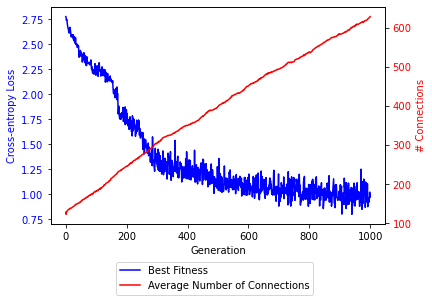

In [27]:
# Plot line for minimum fitness
fig, fit_ax = plt.subplots()
fit_line = fit_ax.plot(gen, fitness_best, "b-", label="Best Fitness")
fit_ax.set_xlabel("Generation")
fit_ax.set_ylabel(f"Cross-entropy Loss", color="b")
for tl in fit_ax.get_yticklabels():
    tl.set_color("b")

# Plot line for average total height
height_ax = fit_ax.twinx()
height_line = height_ax.plot(gen, conn_avg, "r-", label="Average Number of Connections")
height_ax.set_ylabel("# Connections", color="r")
for tl in height_ax.get_yticklabels():
    tl.set_color("r")

# Add legend
lines = fit_line + height_line
labs = [l.get_label() for l in lines]
fit_ax.legend(lines, labs, bbox_to_anchor=(0.8, -0.15))

# Show the result
plt.show()

## Inspecting the best individual

In [28]:
best_ind = hof[0]
print(best_ind)
print(f"Fitness of best individual: {best_ind.fitness}")

MultiClassTree with 191 hidden nodes and 602 connections, born in generation 940
Fitness of best individual: (0.8010749929791497, 0.38237098563713473)


##### Printing trees

In [29]:
# Print the trees of the best individual
for string in best_ind.get_strings():
    print(f"{string}\n")

linear(w, ARG0, ARG4, ARG65, ARG82, ARG126, ARG175, ARG190, ARG225, ARG227, linear(w, ARG156, ARG109), ARG170, ARG64, ARG42, inverse(w, step(w, tanh(w, ARG136, ARG25), relu(w, tanh(w, ARG136, ARG25)), tanh(w, ARG136, ARG25), relu(w, ARG178)), ARG120, ARG136, relu(w, linear(w, ARG152), relu(w, ARG60), inverse(w, ARG181, tanh(w, linear(w, ARG169, inverse(w, inverse(w, ARG132, ARG249, ARG230, step(w, ARG172), ARG37, step(w, inverse(w, cosine(w, step(w, tanh(w, linear(w, ARG196)), linear(w, ARG196)))), step(w, tanh(w, linear(w, ARG196)), linear(w, ARG196)))))), step(w, ARG132, ARG187, ARG162), linear(w, ARG32, ARG242), tanh(w, relu(w, ARG76, ARG230, ARG232), ARG76), relu(w, ARG0)), ARG158, ARG129, ARG147, ARG132, ARG85, ARG237, ARG196)), ARG152), ARG187, sigmoid(w, linear(w, ARG68), absolute(w, relu(w, ARG236, step(w, step(w, ARG196)), step(w, ARG196)), linear(w, ARG170)), ARG170), tanh(w, gaussian(w, linear(w, inverse(w, inverse(w, sigmoid(w, linear(w, gaussian(w, sine(w, step(w, linear(w

##### Computing training & validation accuracy

In [30]:
# Retrieving predictions from an individual
def get_predictions(individual, X, weight):
    func = compile_multiclasstree(individual)
    predictions = []
    for i in range(X.shape[0]):
        outputs_i = func(weight, X[i])
        predictions.append(np.argmax(outputs_i))
    return predictions

In [31]:
# Compute accuracy of predictions
def compute_accuracy(Y_pred, Y_true):
    n_correct = np.sum(Y_pred == Y_true)
    return n_correct/Y_true.shape[0]

In [32]:
# Retrieve predictions of the best individual on the training and validation sets, for all weights
Y_train_pred = np.array([get_predictions(best_ind, X_train, w) for w in WEIGHTS_TO_TEST])
Y_test_pred = np.array([get_predictions(best_ind, X_test, w) for w in WEIGHTS_TO_TEST])

In [33]:
# Compute training accuracies for all weights and extract the best weight
train_accs = [compute_accuracy(Y_train_pred[i], Y_train) for i in range(len(WEIGHTS_TO_TEST))]
test_accs = [compute_accuracy(Y_test_pred[i], Y_test) for i in range(len(WEIGHTS_TO_TEST))]
best_weight_idx_train = np.argmax(train_accs)
best_weight_idx_test = np.argmax(test_accs)

# Print best training and validation accuracies of the best individual
print(f"Best training accuracy (weight {WEIGHTS_TO_TEST[best_weight_idx_train]}): {np.max(train_accs)}")
print(f"Best validation accuracy (weight {WEIGHTS_TO_TEST[best_weight_idx_test]}): {np.max(test_accs)}")

Best training accuracy (weight -2): 0.8055333333333333
Best validation accuracy (weight -2): 0.8139


In [34]:
# Obtain majority votes (in case of a tie, use vote of the best classifier)
def get_majority_predictions(predictions):
    def _majority(l):
        return max(set(l), key=l.count)
    predictions = [_majority(list(predictions[:,i])) for i in range(predictions.shape[1])]
    return predictions

In [35]:
# Compute majority predictions for train and validation sets
Y_train_majpred = get_majority_predictions(Y_train_pred)
Y_test_majpred = get_majority_predictions(Y_test_pred)

# Print the accuracies of the majority votes
print(f"Majority training accuracy: {compute_accuracy(Y_train_majpred, Y_train)}")
print(f"Majority validation accuracy: {compute_accuracy(Y_test_majpred, Y_test)}")

Majority training accuracy: 0.76555
Majority validation accuracy: 0.7719


##### Confusion matrices

In [36]:
# Compute confusion matrices
cm_train_best = confusion_matrix(Y_train, Y_train_pred[best_weight_idx_train], labels=range(N_CLASSES_TO_USE))
cm_test_best = confusion_matrix(Y_test, Y_test_pred[best_weight_idx_test], labels=range(N_CLASSES_TO_USE))
cm_train_maj = confusion_matrix(Y_train, Y_train_majpred, labels=range(N_CLASSES_TO_USE))
cm_test_maj = confusion_matrix(Y_test, Y_test_majpred, labels=range(N_CLASSES_TO_USE))

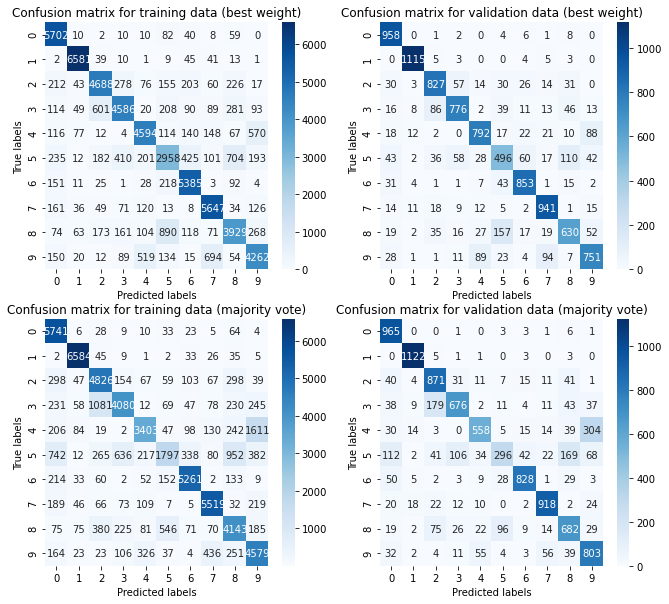

In [37]:
# Create figure
fig, ax = plt.subplots(2,2, figsize=(11,10))
ax = ax.ravel()

# Plot confusion matrix for training data using best weight
sns.heatmap(cm_train_best, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data (best weight)')

# Plot confusion matrix for validation data using best weight
sns.heatmap(cm_test_best, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for validation data (best weight)')

# Plot confusion matrix for training data using majority vote
sns.heatmap(cm_train_maj, annot=True, fmt='g', ax=ax[2], cmap="Blues")
ax[2].set_xlabel('Predicted labels')
ax[2].set_ylabel('True labels')
ax[2].set_title('Confusion matrix for training data (majority vote)')

# Plot confusion matrix for validation data using majority vote
sns.heatmap(cm_test_maj, annot=True, fmt='g', ax=ax[3], cmap="Blues")
ax[3].set_xlabel('Predicted labels')
ax[3].set_ylabel('True labels')
ax[3].set_title('Confusion matrix for validation data (majority vote)')

# Show the result
plt.show()

##### Used features

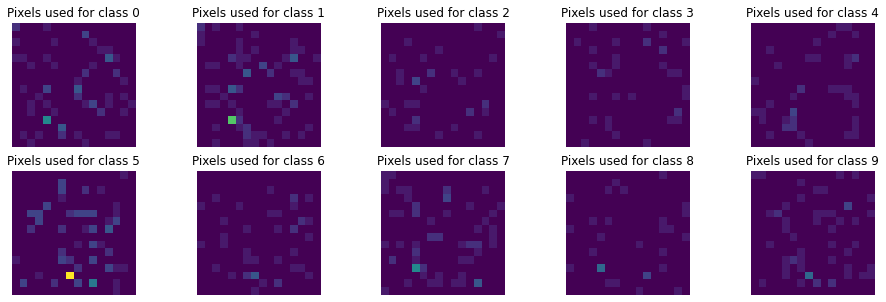

In [38]:
# Extract input tallies from best individual
input_tallies = []
for tree in best_ind.get_strings():
    inputs_used = list(map(int, re.findall("[0-9]+", tree)))
    input_tally = np.zeros(X_train.shape[1])
    for arg in inputs_used:
        input_tally[arg] += 1
    input_tallies.append(input_tally)

# Create plots of the inputs (pixels) used in the tree of the best individual for each class
# Note: for the best-looking plot, this implementation assumes that N_CLASSES_TO_USE is set to 10
fig, ax = plt.subplots(2, 5, figsize=(16,5))
ax = ax.ravel()
for i, tally in enumerate(input_tallies):
    img_shape = int(math.sqrt(X_train.shape[1]))
    ax[i].imshow(np.array(tally).reshape(img_shape, img_shape), clim=(0,np.max(input_tallies)))
    ax[i].axis("off")
    ax[i].set_title(f"Pixels used for class {i}")
plt.show()

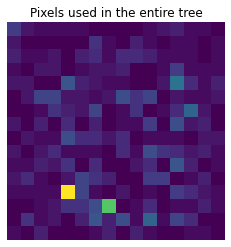

In [39]:
# Plot image of all inputs used in the tree
plt.imshow(np.sum(input_tallies, axis=0).reshape(16,16))
plt.axis("off")
plt.title("Pixels used in the entire tree")
plt.show()